# Bonds 3

This notebook presents a yield curve model (a simplified Vasicek model) and then uses it to improve upon the duration hedging approach.

## Load Packages and Extra Functions

In [1]:
using Dates 

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Predictions from an AR(1)

Consider an AR(1) with mean $\mu$

$r_{t+1}-\mu=\rho\left(  r_{t}-\mu\right)  +\varepsilon_{t+1}$

The forecast (based on information in $t$) for $t+s$ is

$\text{E}_{t}r_{t+s}=\left(  1-\rho^{s}\right)  \mu+\rho ^{s}r_{t}.$

In [3]:
"""
    AR1Prediction(x0,ρ,μ,s)

Calculate forecast from AR(1)

x0,ρ,μ,s: scalars
"""
function AR1Prediction(x0,ρ,μ,s)
    E0xs = (1-ρ^s)*μ + ρ^s*x0
    return E0xs
end

AR1Prediction

In [4]:
ρ = 0.975
μ = 0.05

printlnPs("Prediction for t+50, assuming current r=0.07: ",
          AR1Prediction(0.07,ρ,μ,50))

Prediction for t+50, assuming current r=0.07:      0.056


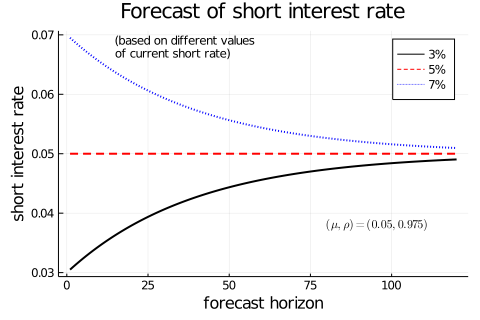

In [5]:
sMax = 120
sM = 1:sMax
x0 = [0.03;0.05;0.07]

xPred = fill(NaN,(sMax,length(x0)))          #one column for each value in x0
for s in sM, j = 1:length(x0)
    xPred[s,j] = AR1Prediction(x0[j],ρ,μ,s)
end


txt = text(latexstring("(\\mu,\\rho) = ($μ,$ρ)"),8,:left)   #latex string to plot
p1 = plot( sM,xPred,
           linecolor = [:black :red :blue],
           linewidth = 2,
           linestyle = [:solid :dash :dot],
           label = ["3%" "5%" "7%"],
           title = "Forecast of short interest rate",
           xlabel = "forecast horizon",
           ylabel = "short interest rate",
           annotation = [(80,0.038,txt),
                    (15,0.068,text("(based on different values\nof current short rate)",8,:left))] )
display(p1)

# The Vasicek Model

The Vasicek model (without risk premia) implies that 

$
y_{t}(n) =a(n)+b(n)r_{t} \: \text{, where }
$

$
b(n)     =(1-\rho^{n})/[(1-\rho)n],
$

$
a(n)     = \mu\left[  1-b(n)\right].
$

If the periods are one month, then $y_{t}(36)$ is the (annualized) continuously compounded interest rate for a bond maturing in 36 months (...3 years).

In [6]:
"""
    Vasicek(r,ρ,μ,n)

Vasicek model: calculate interest rate and (a,b) coeffs
r,ρ,μ,n: scalars
"""
function Vasicek(r,ρ,μ,n)
    if ρ == 1.0
        b = 1.0
    else
        b = (1-ρ^n)/((1-ρ)*n)
    end
    a = μ*(1-b)
    y = a + b*r
    return y,a,b
end

Vasicek

In [7]:
yM = fill(NaN,(sMax,length(x0)))        #interest rates, different starting values in columns
ab = fill(NaN,(sMax,2))                 #a and b coefs 
for n in sM, j = 1:length(x0)
    #local a, y, b                      #only needed in script
    (y,a,b) = Vasicek(x0[j],ρ,μ,n)
    yM[n,j] = y
    if j == 1
        ab[n,:] = [a b]                     #the same across x0 values
    end    
end

printblue("a and b for the first few horizons (months):")
printTable([ab[1:4,1]*100 ab[1:4,2]],["a*100","b"],string.(sM[1:4]),cell00="horizon")

a and b for the first few horizons (months):
horizon     a*100         b
1           0.000     1.000
2           0.062     0.988
3           0.124     0.975
4           0.184     0.963



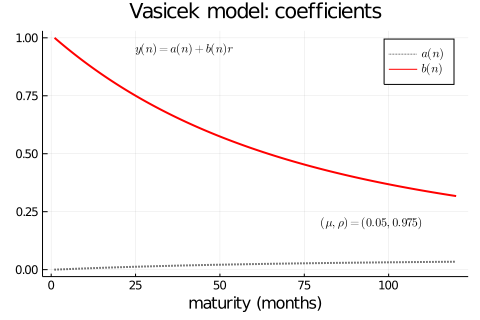

In [8]:
p1 = plot( sM,ab,
           linecolor = [:black :red],
           linestyle = [:dot :solid],
           linewidth = 2,
           label = [L"a(n)" L"b(n)"],
           title = "Vasicek model: coefficients",
           xlabel = "maturity (months)",
           annotation = [(80,0.2,txt),
                    (25,0.95,text(L"y(n) = a(n) + b(n)r",8,:left))] )
display(p1)

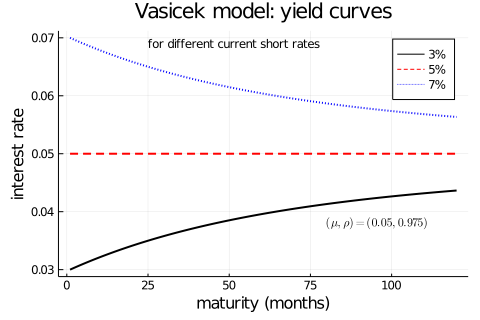

In [9]:
p1 = plot( sM,yM,
           linecolor = [:black :red :blue],
           linewidth = 2,
           linestyle = [:solid :dash :dot],
           label = ["3%" "5%" "7%"],
           title = "Vasicek model: yield curves",
           xlabel = "maturity (months)",
           ylabel = "interest rate",
           annotation = [(80,0.038,txt),
                    (25,0.069,text("for different current short rates",8,:left))] )
display(p1)

# Hedging Using the Vasicek Model

Recall that the change of the (value of the) hedge portfolio is 

$\begin{equation}
\Delta V=v\Delta P_{H}-\Delta P_{L}
\end{equation}$


A. For an initial value of the short log interest rate $r$, use the Vasicek model to calculate all spot rates needed to value the bond portfolios. Repeat for a somewhat different short rate.

B. Use the two sets of spot interest rates ($y(m)$) to calculate (two different) prices of both the liability and the hedge bond. 

C. Calculate the $v$ value that makes $\Delta V = 0$, that is, $v=\Delta P_{L}/\Delta P_{H}$.

In [10]:
"""
y:  scalar or K vector of continuously compounded interest rates
cf: scalar or K vector of cash flows
m: K vector of times of cash flows
"""
function BondPrice3b(y,cf,m)                #cf is a vector of all cash flows
    cdisc = cf./exp.(m.*y)
    P     = sum(cdisc)                      #price
    return P
end

BondPrice3b

## A. Calculate Yield Curves

at two different values of the current short rate: $r_0$ and $r_1$.

In [11]:
ρ = 0.975                       #experiment with this
μ = 0.05

r₀ = 0.05                         #initial (day 0) short log interest rate
r₁ = 0.049                        #another possible short rate

nL  = 1:120                       #times of the cash flows of liability, months
nH  = 1:36                        #same, but for hedge bond
nMax = maximum([nL;nH])           #calculate yield curves for at least this maturity 

(y₀,y₁) = [fill(NaN,nMax) for i=1:2]  #yield curve, before and after
 for n in 1:nMax
    y₀[n] = Vasicek(r₀,ρ,μ,n)[1]
    y₁[n] = Vasicek(r₁,ρ,μ,n)[1]
end

## B. Calculate the Prices of the Hedge Bond and the Liability

In the example below, the liability pays 0.2 every 12 months for 10 years. The hedge bond is a 3-year zero coupon bond. 

The Vasicek model is here implemented such that periods are months, that is, `y[36]` is the (annualized, continuously compounded) interest rate for a 36 month bond.

With the two yield curves (different short rate values) from the Vasicek model, calculate prices of the hedge bond and the liability.

Recall, the bond price $P$ is the present value of the future cash flows $cf_k$

$P = \sum_{k=1}^{K} \frac{cf_{k}}{\exp\left[m_{k} y(m_{k})\right]  }$,

where $y(m_k)$ is the continuously compounded (annualized) interest rate on a bond maturing in $m_k$ years.

In [12]:
cfL = repeat([zeros(11);0.2],10)         #cash flow of liability
cfH = [zeros(35);1]                      #cash flow of hedge bond, 3-year zero-coupon bond

PL₀ = BondPrice3b(y₀[nL],cfL,nL/12)       #liability, before, /12 to get years
PL₁ = BondPrice3b(y₁[nL],cfL,nL/12)       #after 
ΔPL = PL₁ - PL₀

PH₀ = BondPrice3b(y₀[nH],cfH,nH/12)       #hedge bond
PH₁ = BondPrice3b(y₁[nH],cfH,nH/12)
ΔPH = PH₁ - PH₀

printblue("Bond prices (according to the Vasicek model) at different r values")
xy = [PL₀ PH₀;PL₁ PH₁]
printTable(xy,["PL","PH"],["$r₀","$r₁"])

Bond prices (according to the Vasicek model) at different r values
             PL        PH
0.05      1.535     0.861
0.049     1.538     0.862



## C. Calculate the Hedge Ratio

Calculate the hedge ratio as

$
v = \Delta P_L / \Delta P_H.
$

In [13]:
v = ΔPL/ΔPH                              #change PL/change PH

printblue("Hedge ratio from the Vasicek model:")
xy = [v;v*PH₀/PL₀]
printTable(xy,[""],["v","v*PH₀/PL₀"])

printred("Notice: ρ is important for the hedge ratio. Try also ρ=1 to see how h changes")

Hedge ratio from the Vasicek model:
                   
v             2.094
v*PH₀/PL₀     1.174

Notice: ρ is important for the hedge ratio. Try also ρ=1 to see how h changes
